# Image Interpolation with Transposed Convolution

Auxiliary exercise, where the goal it to "manually" interpolate 2D images using conv-transposed operation implemented by troch.

### Resources

* [Medium](https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
* [Distill](https://distill.pub/2016/deconv-checkerboard/)
* [TDS](https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37)

### Setup

In [1]:
import sys

sys.path.append("../src/")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from scipy import sparse, stats, interpolate, signal
from skimage import io, transform, color
from sklearn import metrics

In [3]:
color_image = io.imread(r"../data/image.jpg")
color_image = transform.resize(color_image, output_shape=(1000, 1000, 3))

grey_image = color.rgb2gray(color_image)  # convert to grey-scale to work with both
grey_image.shape, color_image.shape

((1000, 1000), (1000, 1000, 3))

### Torch

PyTorch is used to skip implementing conv-transpose by hand, but instead see how a network layer would run this operation. 

In [4]:
def image_to_tensor(image):
    """Convert 2D numpy image to tensor (as batch) ready to be passed to the network layer"""
    if image.ndim == 2:  # grey image
        tensor_image = torch.from_numpy(image)
        # unsqueeze two times, for channel and batch dimension
        tensor_image = torch.unsqueeze(torch.unsqueeze(tensor_image, dim=0), dim=0)
        return tensor_image.to(torch.float32)
    elif image.ndim == 3:  # color image
        tensor_image = torch.from_numpy(image)
        tensor_image = tensor_image.permute(2, 0, 1)
        tensor_image = torch.unsqueeze(tensor_image, dim=0)
        return tensor_image.to(torch.float32)
    
    raise ValueError(f"This shape {image.shape} is for sure not an image shape!")

    
def tensor_to_image(tensor):
    return torch.squeeze(tensor).detach().numpy()

In [5]:
def get_upsampler(kernel):
    size = kernel.shape[0]  # assuming it is a square matrix!
    layer = torch.nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=size, stride=size, bias=False)
    # write in weights manually using kernel
    layer.weight.data = image_to_tensor(kernel)
    return layer

Create 2D linear kernel using 2D grind with size 3x3 and 2D kernel function

In [6]:
size = 3

grid = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
grid = np.dstack(grid)
grid.shape  # shape -> (kernel_size, kernel_size, 2)

(3, 3, 2)

In [7]:
kernel = np.ones([size, size])  # linear interpolation
kernel.shape

(3, 3)

In [8]:
upsampler = get_upsampler(kernel)

In [9]:
output = upsampler(image_to_tensor(grey_image))
output = tensor_to_image(output)
output.shape

(3000, 3000)

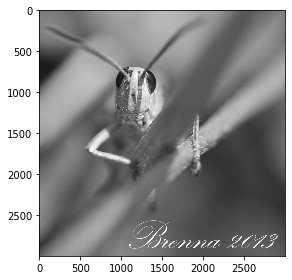

In [10]:
_ = io.imshow(output)